In [1]:
import sys
import os 
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Model libraries
sys.path.append("../InformationPercolation/code")
from FX_infoperc.fastvecm import fastDailyVECM
import example_utilities as eutil

# import warnings 
# warnings.filterwarnings('ignore')

In [14]:
# Save data
SAVE = True                # Should save the outputs from the run

if SAVE:
    save_base_path = "output/" # Top directory
    save_subpath   = "test1"   # Subdirectory
    save_fullpath  = save_base_path + save_subpath
    eutil.create_directories_for_output(save_base_path, save_fullpath)


Main directory output/ already exists!
Successfully created the directory output/test1 
Main directory created!


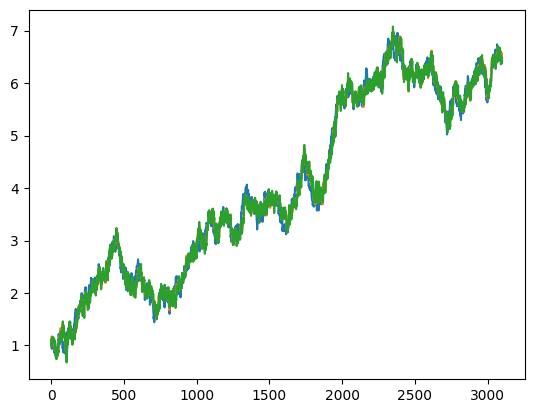

,TimeStep,MarketId,Bid,Ask
0,0,0,1.000000,1.000000
1,0,1,1.000000,1.000000
2,0,2,1.000000,1.000000
3,100,0,0.980243,0.980243
4,100,1,0.986599,0.986599
...,...,...,...,...
9295,309800,1,6.519010,6.519010
9296,309800,2,6.381828,6.381828
9297,309900,0,6.429791,6.429791
9298,309900,1,6.562480,6.562480


In [3]:
# Generating sample data
markets =  ['A', 'B', 'C']
market_nbs = [0,1,2] # Ids corresponding to dealer A, B, C, respectively needs to start from 0!
num_venues = len(market_nbs)
time_set = np.arange(0, 310000, 100)

couplingBtoA = 0.1 # coupling of B[t] to A[t-1] - max 1 
couplingCtoB = 0.9 # coupling of C[t] to B[t-1] - max 1

A_dealer, B_dealer, C_dealer = eutil.simulate3dealers(time_set, couplingBtoA, couplingCtoB)

data = {
        'TimeStep': np.repeat(time_set, num_venues),
        'MarketId': np.tile(market_nbs, len(time_set)),
        'Bid'     : np.column_stack([A_dealer, B_dealer, C_dealer]).ravel(),
        'Ask'     : np.column_stack([A_dealer, B_dealer, C_dealer]).ravel(),
}

df = pd.DataFrame(data)

plt.plot(A_dealer)
plt.plot(B_dealer)
plt.plot(C_dealer)
plt.show()
df

In [4]:
# Running the model

# Sampling parameters
sampling_period  = 100    # ms
window_size_min  = 5      # min
step_size_min    = 5      # min

# VECM parameters
num_threads      = 8    # maximum number of threads
max_lag_num_VECM = 20   # max VECM lag 20
max_lag_IRF      = 50   # IRF horizon 50
min_obs          = 10   # minimum observations 10
infotheo_model   = 1    # 1-with INA / 0-without INA
lag_num_edges    = 1 


# INA parameters
TE_auto        = 1    # determine history and embedding using Ragwitz criterion (1- true, 0 -false)
TE_hist        = 2    # maximum history length if TE_auto = 1, else the history length used
TE_tau         = 2    # maximum embeding delay if TE_auto = 1, else the embedding delay used
TE_permutation = 100  # number of permutations to be perfomed for p-value estimation


# Translating input data to miliseconds
window_size_ms = eutil.time_to_ms(0, window_size_min)
step_size_ms   = eutil.time_to_ms(0, step_size_min)
period_start   = time_set[0]
period_end     = time_set[-1]

# Create a numpy array for time, representing some arbitrary time points
time_set = np.require(df.TimeStep.astype(int), np.int32, ['F', 'A'])
market_id = np.require(df.MarketId, np.int32, ['F', 'A'])
ask = np.require(df.Ask, np.double, ['F', 'A'] )
bid = np.require(df.Bid, np.double, ['F', 'A'])

# Model
fdm = fastDailyVECM(time_set, market_id, ask, bid)
fdm.init(sampling_period, window_size_ms, step_size_ms, period_start, period_end)

fdm.run( num_threads,
         max_lag_num_VECM,
         max_lag_IRF,
         lag_num_edges,
         min_obs,
         infotheo_model,
         TE_hist,
         TE_tau,
         TE_permutation,
         TE_auto)

nb_of_windows = fdm.beta_inefficiency.shape[0]

In [5]:
# Saving settings to text file for future reference
f= open(save_fullpath+"/run_settings.txt", "w+")

f.write(f" SETTINGS: \n \
    sampling_period   =  {sampling_period  } \n \
    window_size_min   =  {window_size_min  } \n \
    step_size_min     =  {step_size_min    } \n \
    num_threads       =  {num_threads      } \n \
    max_lag_num_VECM  =  {max_lag_num_VECM } \n \
    max_lag_IRF       =  {max_lag_IRF      } \n \
    min_obs           =  {min_obs          } \n \
    infotheo_model    =  {infotheo_model   } \n \
    TE_hist           =  {TE_hist          } \n \
    TE_tau            =  {TE_tau           } \n \
    TE_permutation    =  {TE_permutation   } \n \
    TE_auto           =  {TE_auto          } \n \
    NB OF WINDOWS     =  {nb_of_windows    } \n \
    NB OF VENUES      =  {num_venues       }")

f.close()

In [6]:
# Extract all the data from the fdm object
TE               = fdm.TE.reshape(nb_of_windows, num_venues, num_venues)
TE_pval          = fdm.TE_pval.reshape(nb_of_windows, num_venues,num_venues)
CTE              = fdm.CTE.reshape(nb_of_windows, num_venues,num_venues)
CTE_pval         = fdm.CTE_pval.reshape(nb_of_windows, num_venues,num_venues)

beta_ineff       = fdm.beta_inefficiency.reshape(nb_of_windows, max_lag_IRF,num_venues )
edges_corr       = fdm.edges_corr.reshape(nb_of_windows, max_lag_IRF, num_venues,num_venues )
S_lower          = fdm.S_lower.reshape(nb_of_windows,num_venues)
S_upper          = fdm.S_upper.reshape(nb_of_windows,num_venues)
included         = fdm.included.reshape(nb_of_windows,num_venues)
wind_start_times = fdm.time
spread           = fdm.spread.reshape(nb_of_windows, num_venues)

In [7]:
# Saving all of the data
if SAVE ==True:
    np.save(save_fullpath + "/arrays/raw/beta_ineff.npy", beta_ineff)
    np.save(save_fullpath + "/arrays/raw/edges_corr.npy", edges_corr)
    np.save(save_fullpath + "/arrays/raw/S_lower.npy", S_lower)
    np.save(save_fullpath + "/arrays/raw/S_upper.npy", S_upper)
    np.save(save_fullpath + "/arrays/raw/included.npy", included)
    np.save(save_fullpath + "/arrays/raw/wind_start_times.npy", wind_start_times)
    np.save(save_fullpath + "/arrays/raw/spread.npy", spread)
    np.save(save_fullpath + "/arrays/raw/TE.npy", TE)
    np.save(save_fullpath + "/arrays/raw/TE_pval.npy", TE_pval)
    np.save(save_fullpath + "/arrays/raw/CTE.npy", CTE)
    np.save(save_fullpath + "/arrays/raw/CTE_pval.npy", CTE_pval)
    print("Saving Results Completed!")
else:
    print("Results not saved !")

Saving Results Completed!


In [8]:
plot_window = 0 # which window to be plotted
DF_TE = pd.DataFrame(data=np.round(TE[plot_window],4), columns = markets, index=markets)

DF_TE

,A,B,C
A,NaN,NaN,0.0166
B,NaN,NaN,0.1966
C,NaN,NaN,NaN


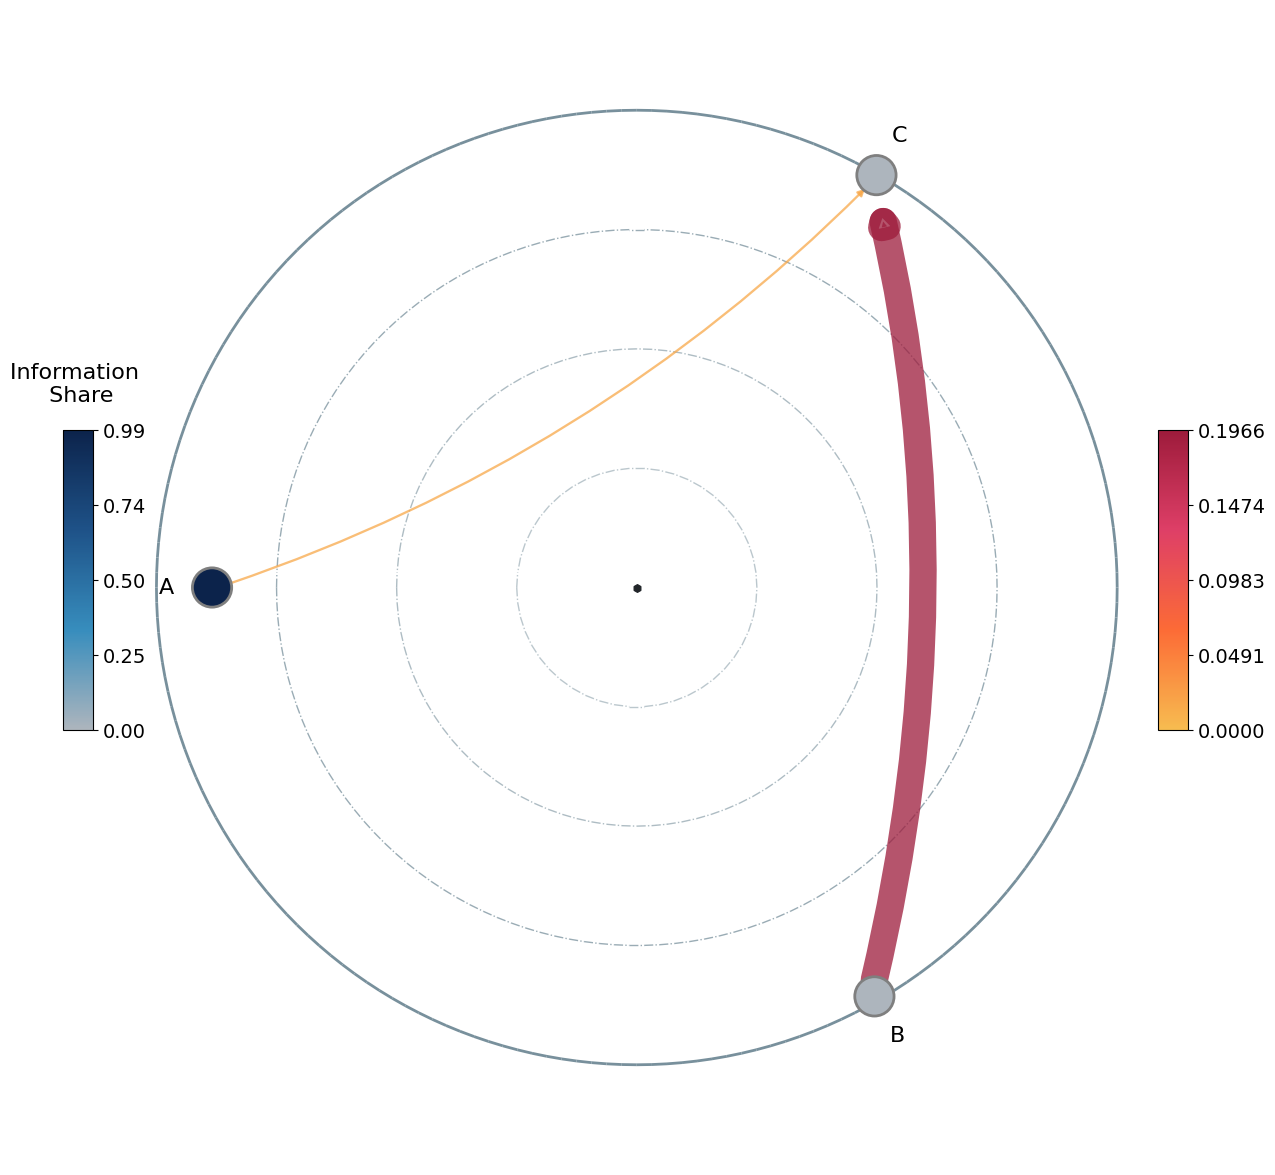

In [15]:
eutil.plot_map(beta_ineff[plot_window][0], TE[plot_window], S_lower[plot_window], markets, save_fullpath +"/figures/fig_TE.pdf", SAVE)

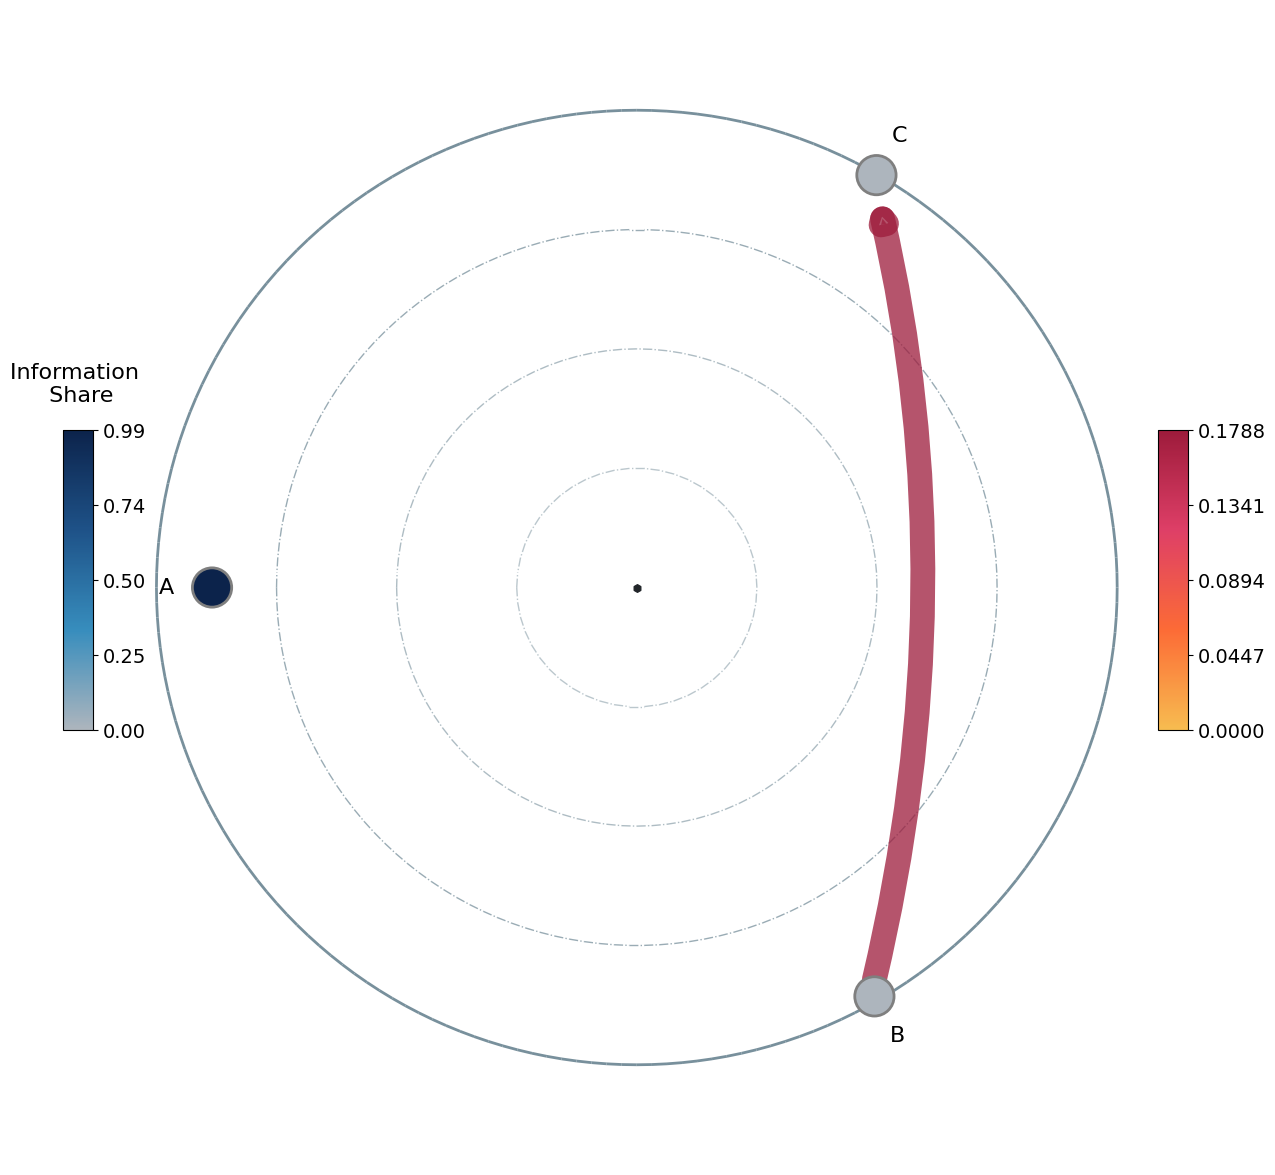

In [16]:
plot_window = 0 # which window to be plotted
eutil.plot_map(beta_ineff[plot_window][0], CTE[plot_window], S_lower[plot_window], markets, save_fullpath +"/figures/fig_CTE.pdf", SAVE)

In [11]:
DF_CTE = pd.DataFrame(data=np.round(CTE[plot_window],4), columns = markets, index=markets)
DF_CTE

,A,B,C
A,0.0,0.0,0.0000
B,0.0,0.0,0.1788
C,0.0,0.0,0.0000
